<a href="https://colab.research.google.com/github/marco-siino/gpt_energy_cost_optimization/blob/main/Mistral7B_Energy_Cost_Optimization_MSiino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download model and libraries.

Installing dependencies. You might need to tweak the CMAKE_ARGS for the `llama-cpp-python` pip package.

In [1]:
# GPU llama-cpp-python; Starting from version llama-cpp-python==0.1.79, it supports GGUF
!CMAKE_ARGS="-DLLAMA_CUBLAS=on " pip install 'llama-cpp-python>=0.1.79' --force-reinstall --upgrade --no-cache-dir
# For download the models
!pip install huggingface_hub
!pip install datasets

import datasets
from datasets import load_dataset
from datetime import datetime, timedelta
import json
import re
import random
import numpy as np
import tqdm.notebook as tqdm
from huggingface_hub import hf_hub_download
import tensorflow as tf
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 164.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 307.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 247.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 287.3 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.2.62-cp310-cp310-manylinux_2_35_x86_64.whl size=38975790 sha256=a24a20bca28eece4ad7ce96f5c4c69cf232cbbfd4fc26807b67d87d22828ce4b
  Stored in directory: /tmp/pip-ephem-wheel-cache-uv4tk_ag/wheels/c0/81/de/d4cc8f152d89865379dbf28ca672358c667192ee55deaca7cb
Successfully built llama-cpp-python
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-

Downloading an instruction-finetuned Mistral model.

In [2]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

# This config has been tested on an RTX 3080 (VRAM of 16GB).
# you might need to tweak with respect to your hardware.
from llama_cpp import Llama
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=4, #16, # CPU cores
    n_batch=800, #8000, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32, # Change this value based on your model and your GPU VRAM pool.
    n_ctx=8192, # Context window
    logits_all=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loade

# Get the dataset.

In [3]:
import requests
import os
import numpy as np
from datetime import datetime
!pip install py7zr
from py7zr import unpack_7zarchive

def download_and_extract(url, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Download the file
    response = requests.get(url)
    if response.status_code == 200:
        # Save the downloaded file
        filename = os.path.join(output_dir, "archive.7z")
        with open(filename, "wb") as f:
            f.write(response.content)

        # Extract the contents of the archive
        with open(filename, 'rb') as f:
            unpack_7zarchive(f, output_dir)

        print("Extraction completed.")
    else:
        print("Failed to download the file.")

# Example usage:
url = "https://pureportal.strath.ac.uk/files/52873459/Processed_Data_CSV.7z"
output_directory = "extracted_contents"
download_and_extract(url, output_directory)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 69.4 MB/s eta 0:00:00
Extraction completed.


# Dataset structure.
Each CSV file corresponds to a House. For each house there are always 9 appliances. The corresponding description of each appliance is reported below.

House 1

0.Aggregate, 1.Fridge, 2.Chest Freezer, 3.Upright Freezer, 4.Tumble Dryer,
5.Washing Machine, 6.Dishwasher, 7.Computer Site, 8.Television Site, 9.Electric Heater
	!NOTES
		0. October 2014, numerous light bulbs changed to LEDs.
		7.a Desktop Computer
		7.b Computer Monitor

House 2

0.Aggregate, 1.Fridge-Freezer, 2.Washing Machine, 3.Dishwasher, 4.Television,
5.Microwave, 6.Toaster, 7.Hi-Fi, 8.Kettle, 9.Oven Extractor Fan
	!NOTES

House 3

0.Aggregate, 1.Toaster, 2.Fridge-Freezer, 3.Freezer, 4.Tumble Dryer,
5.Dishwasher, 6.Washing Machine, 7.Television, 8.Microwave, 9.Kettle
	!NOTES

House 4

0.Aggregate, 1.Fridge, 2.Freezer, 3.Fridge-Freezer, 4.Washing Machine (1),
5.Washing Machine (2), 6.Computer Site, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES
		6.a Desktop Computer
		6.b Computer Monitor
		6.c Scanner
		6.d Printer
		6.e Router
		6. Change in signature 01/02/2015
		7.a Television
		7.b DVD Player
		7.c VHS Player
		7. Change in signature 19/12/2014

House 5

0.Aggregate, 1.Fridge-Freezer, 2.Tumble Dryer 3.Washing Machine, 4.Dishwasher,
5.Computer Site, 6.Television Site, 7.Combination Microwave, 8.Kettle, 9.Toaster
	!NOTES
		2. Dehumidifier added on 21/11/2014
		5.a Desktop Computer
		5.b Computer Monitor
		5.c Printer
		5.d Speakers
		5. Change in signature 27/01/2015
		6.a Television w/DVD Player
		6.b Set-top Box
		6.c Games Console

House 6

0.Aggregate, 1.Freezer (Utility Room), 2.Washing Machine, 3.Dishwasher, 4.MJY Computer,
5.Television Site, 6.Microwave, 7.Kettle, 8.Toaster, 9.PGM Computer
	!NOTES
		4.a Desktop Computer
		4.b Computer Monitor
		4.c Computer Monitor
		4.d Printer
		5.a Television
		5.b Set-top Box
		5.c PC
		5.d DVD Player
		9.a Desktop Computer
		9.b Computer Monitor
		9.c Printer
		9.d Shredder

House 7

0.Aggregate, 1.Fridge, 2.Freezer (Garage), 3.Freezer, 4.Tumble Dryer,
5.Washing Machine, 6.Dishwasher, 7.Television Site, 8.Toaster, 9.Kettle
	!NOTES
		3. Change in signature 24/11/13
		6. Change in signature 20/05/14
		7.a Television
		7.b Speakers
		7.c Telephone

House 8

0.Aggregate, 1.Fridge, 2.Freezer, 3.Dryer, 4.Washing Machine,
5.Toaster, 6.Computer, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES
		1. Change in Fridge Nov 6th
		5.a Toaster
		5.b DAB Radio
		7.a Television
		7.b DVD Player
		7.c VHS Player
		7.d Sound Bar

House 9

0.Aggregate, 1.Fridge-Freezer, 2.Washer Dryer, 3.Washing Machine, 4.Dishwasher,
5.Television Site, 6.Microwave, 7.Kettle, 8.Hi-Fi, 9.Electric Heater
	!NOTES
		5.a Television
		5.b Sky Box
		5.c DVD Player

House 10

0.Aggregate, 1.Magimix (Blender), 2.Freezer, 3.Chest Freezer (In Garage), 4.Fridge-Freezer,
5.Washing Machine, 6.Dishwasher, 7.Television Site, 8.Microwave, 9. Kenwood KMix
	!NOTES
		1. Changed from Fridge to Blender on 17/06/2014
		2. Changed from Freezer to Toaster on 25/06/2014.
		3. Post April 2015, included a second Freezer (both located in Garage)
		4. Changed from Whirlpool ART 500-9/G/1 to AEG SKZ71800F0 March 2015 (Both Fridge-Freezer)
		7.a. TV
		7.b. DVD Player
		7.c. Set-top Box
		7.d. Router
		7.e. Network storage External power supply
		7.f. Laptop external power supply

House 11

0.Aggregate, 1.Fridge, 2.Fridge-Freezer, 3.Washing Machine, 4.Dishwasher,
5.Computer Site, 6.Microwave, 7.Kettle, 8.Router, 9.Hi-Fi
	!NOTES
		0. Aggregate is affected by Solar Panels.
		4. Possible dishwasher replacement

House 12

0.Aggregate, 1.Fridge-Freezer, 2.Television Site(Lounge), 3.Microwave, 4.Kettle,
5.Toaster, 6.Television Site(Bedroom), 7.Not Used, 8.Not Used, 9.Not Used
	!NOTES

House 13

0.Aggregate, 1.Television Site, 2.Unknown, 3.Washing Machine, 4.Dishwasher,
5.Tumble Dryer, 6.Television Site, 7.Computer Site, 8.Microwave, 9.Kettle
	!NOTES
		1.a Television
		1.b Xbox
		1.c Wii
		2. Has a device attached which was not recorded.
		5. Signature changes with no mention of devices attached.
		6.a Television
		6.b Computer
		6.c Current Cost
		7.a Laptop Dock
		7.b Camera System (July-Aug 2014)

House 15

0.Aggregate, 1.Fridge-Freezer, 2.Tumble Dryer, 3.Washing Machine, 4.Dishwasher,
5.Computer Site, 6.Television Site, 7.Microwave, 8.Kettle , 9.Toaster
	!NOTES
		5.a Desktop Computer
		5.b Printer
		6.a Television
		6.b Xbox
		6.c Set-top Box

House 16

0.Aggregate, 1.Fridge-Freezer (1), 2.Fridge-Freezer (2), 3.Electric Heater (1)?,
4.Electric Heater (2), 5.Washing Machine, 6.Dishwasher, 7.Computer Site,
8.Television Site, 9.Dehumidifier/Heater
	!NOTES
		8.a Television
		8.b DVD/Blue-ray Player
		8.c Wii
		8.d Speakers

House 17

0.Aggregate, 1.Freezer (Garage), 2.Fridge-Freezer, 3.Tumble Dryer (Garage), 4.Washing Machine,
5.Computer Site, 6.Television Site, 7.Microwave, 8.Kettle, 9.Plug Site (Bedroom)
	!NOTES
		1. Was replaced 1 month before recording stopped with smaller capacity Freezer.
		2. Was replaced mid May 2015.
		5.a Desktop
		5.b Computer Monitor
		5.c Computer Monitor
		5.d Printer
		8.a Kettle
		8.b Toaster & Misc (Occasionally plugged in)
		9.a Television
		9.b Laptop
		9.c Hair Dryer
		9.d Phone Charger

House 18

0.Aggregate, 1.Fridge(garage), 2.Freezer(garage), 3.Fridge-Freezer,
4.Washer Dryer(garage), 5.Washing Machine, 6.Dishwasher, 7.Desktop Computer,
8.Television Site, 9.Microwave
	!NOTES
		8.a Television
		8.b DVD Player
		8.c Sky Box
		8.d Speakers
		8.e Lamp
		8.f HiFi

House 19

0.Aggregate, 1.Fridge & Freezer, 2.Washing Machine, 3.Television Site, 4.Microwave,
5.Kettle, 6.Toaster, 7.Bread-maker, 8.Lamp (80Watts), 9.Hi-Fi
	!NOTES
		1. This plug has a fridge AND a freezer attached on the same IAM
		3.a Television
		3.b DVD Player

House 20

0.Aggregate, 1.Fridge, 2.Freezer, 3.Tumble Dryer, 4.Washing Machine, 5.Dishwasher,
6.Computer Site, 7.Television Site, 8.Microwave, 9.Kettle
	!NOTES

House 21

0.Aggregate, 1.Fridge-Freezer, 2.Tumble Dryer, 3.Washing Machine,
4.Dishwasher, 5.Food Mixer, 6.Television, 7.Kettle/Toaster, 8.Vivarium, 9.Pond Pump
	!NOTES
		House 21 Aggregate is affected by Solar Panels.

# Make a dictionary for House 1. (Ex. Key-Value -> Fridge-Appliance1)

In [4]:
appliances = [
    "Fridge", "Chest Freezer", "Upright Freezer", "Tumble Dryer",
    "Washing Machine", "Dishwasher", "Computer Site", "Television Site",
    "Electric Heater"
]

appliances_dict = {f"Appliance{i+1}": appliance for i, appliance in enumerate(appliances)}


In [5]:
print(appliances_dict)

{'Appliance1': 'Fridge', 'Appliance2': 'Chest Freezer', 'Appliance3': 'Upright Freezer', 'Appliance4': 'Tumble Dryer', 'Appliance5': 'Washing Machine', 'Appliance6': 'Dishwasher', 'Appliance7': 'Computer Site', 'Appliance8': 'Television Site', 'Appliance9': 'Electric Heater'}


# Make the dataframe from the dataset.

In [6]:
import pandas as pd

def read_csv_to_dataframe(csv_file):
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(csv_file)
    return df

# Example usage:
dataframe = read_csv_to_dataframe("extracted_contents/House_1.csv")
print(dataframe)


                        Time        Unix  Aggregate  Appliance1  Appliance2  \
0        2013-10-09 13:06:17  1381323977        523          74           0   
1        2013-10-09 13:06:31  1381323991        526          75           0   
2        2013-10-09 13:06:46  1381324006        540          74           0   
3        2013-10-09 13:07:01  1381324021        532          74           0   
4        2013-10-09 13:07:15  1381324035        540          74           0   
...                      ...         ...        ...         ...         ...   
6960003  2015-07-10 11:56:05  1436529365        187           0          45   
6960004  2015-07-10 11:56:12  1436529372        185           0          45   
6960005  2015-07-10 11:56:18  1436529378        181           0          45   
6960006  2015-07-10 11:56:25  1436529385        186           0          45   
6960007  2015-07-10 11:56:32  1436529392        182           0          45   

         Appliance3  Appliance4  Appliance5  Applia

# With the next cell it is possible to see the working load of a fridge. The pattern is quite regular.

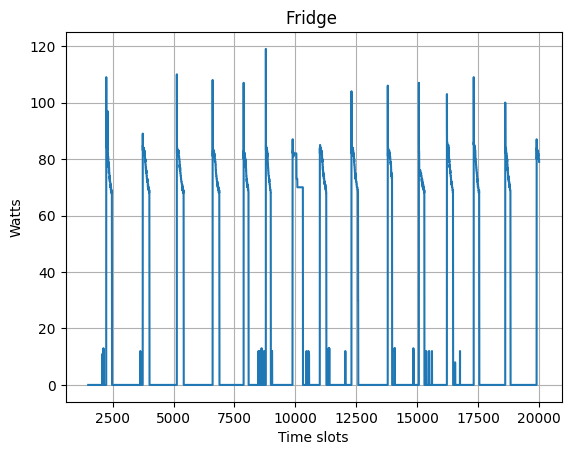

In [7]:
import matplotlib.pyplot as plt

# Plot all the values in 'Column1'
dataframe['Appliance1'][1500:20000].plot()

# Add labels and title
plt.xlabel('Time slots')
plt.ylabel('Watts')
plt.title('Fridge ')
plt.grid("True")

# Show the plot
plt.show()

# Store the average consumptions of each appliance in the house.

In [8]:
def calculate_avg_appliance_consumption(appliance):

  # Find the maximum and minimum non-zero values
  max_non_zero = dataframe[appliance][dataframe[appliance] != 0].max()
  min_non_zero = dataframe[appliance][dataframe[appliance] != 0].min()

  # Filter the DataFrame to include only values between the maximum and minimum
  filtered_values = dataframe[(dataframe[appliance] > min_non_zero) & (dataframe[appliance] < max_non_zero)][appliance]

  # Calculate the average of the filtered values
  average_between_non_zero = filtered_values.mean()

  return average_between_non_zero

In [9]:
# Save the average consumption of any device in a list.
avg_appliances_consumptions = {}

for i in range(1, len(appliances_dict)+1):
  avg_appliances_consumptions[appliances_dict["Appliance"+str(i)]]=calculate_avg_appliance_consumption("Appliance"+str(i))
  #avg_appliances_consumptions.append((appliances_dict["Appliance"+str(i)],calculate_avg_appliance_consumption("Appliance"+str(i))))

print(avg_appliances_consumptions)

f1_cost= 0.07138
f23_cost= 0.06999

{'Fridge': 75.79845793092484, 'Chest Freezer': 48.08923243274837, 'Upright Freezer': 72.21469605959662, 'Tumble Dryer': 472.6271729522687, 'Washing Machine': 513.3838271002094, 'Dishwasher': 1379.0888017181703, 'Computer Site': 29.738480373322528, 'Television Site': 31.700847769012388, 'Electric Heater': 1007.2853867493128}


# Sostituisco ora tutti i valori in watts presenti con ON e OFF.

In [10]:
discretized_dataframe = dataframe
for i in range(1,len(appliances_dict)+1):
  discretized_dataframe["Appliance"+str(i)] = np.where(dataframe["Appliance"+str(i)] != 0, 'ON', 'OFF')

In [11]:
print(discretized_dataframe)

                        Time        Unix  Aggregate Appliance1 Appliance2  \
0        2013-10-09 13:06:17  1381323977        523         ON        OFF   
1        2013-10-09 13:06:31  1381323991        526         ON        OFF   
2        2013-10-09 13:06:46  1381324006        540         ON        OFF   
3        2013-10-09 13:07:01  1381324021        532         ON        OFF   
4        2013-10-09 13:07:15  1381324035        540         ON        OFF   
...                      ...         ...        ...        ...        ...   
6960003  2015-07-10 11:56:05  1436529365        187        OFF         ON   
6960004  2015-07-10 11:56:12  1436529372        185        OFF         ON   
6960005  2015-07-10 11:56:18  1436529378        181        OFF         ON   
6960006  2015-07-10 11:56:25  1436529385        186        OFF         ON   
6960007  2015-07-10 11:56:32  1436529392        182        OFF         ON   

        Appliance3 Appliance4 Appliance5 Appliance6 Appliance7 Appliance8  

# La cella seguente contiene la funzione che riceve in input il giorno e l'appliance e in output restituisce tutti gli intervalli di funzionamento, ovvero orari (inizio e fine) di ON.

In [37]:
def get_daily_appliance_operating_times(df,day,appliance):
  df['timestamp'] = pd.to_datetime(df['Time'])
  day_to_filter = day

  # Parse the input date string into a datetime object
  date_obj = datetime.strptime(day, '%Y-%m-%d')
  # Get the day of the week (e.g., "Monday")
  day_of_week = date_obj.strftime('%A')  # Return the day name directly

  # Filter rows related to the specific day
  filtered_df = df[df['timestamp'].dt.date == pd.to_datetime(day_to_filter).date()]
  filtered_df.reset_index(drop=True, inplace=True)

  if filtered_df.empty:
    return "The day you have selected is not in the dataset."

  # Initialize lists to store indices of status changes
  on_to_off_indices = []
  off_to_on_indices = []

  # Iterate over the DataFrame
  for i in range(1, len(filtered_df)):
      if filtered_df[appliance][i - 1] == 'ON' and filtered_df[appliance][i] == 'OFF':
          on_to_off_indices.append(i)
      elif filtered_df[appliance][i - 1] == 'OFF' and filtered_df[appliance][i] == 'ON':
          off_to_on_indices.append(i)

  #print("Indices where status changes from ON to OFF:", on_to_off_indices)
  #print("Indices where status changes from OFF to ON:", off_to_on_indices)

  prompt = "During the day: " +day+" ("+ day_of_week+"), the appliance was ON at these times:\n"

  # Now manage the case of the appliance either ON or OFF all day long.
  if (filtered_df[appliance] == 'ON').all():
    # Case of an appliance always ON during the current day.
    prompt += "From: 00:00:00 To: 23:59:59\n"
    return prompt
  if (filtered_df[appliance] == 'OFF').all():
    # Case of an appliance always OFF during the current day.
    prompt = "During the day: " +day+" ("+ day_of_week+"), the appliance was never ON.\n"
    return prompt

  # Now manage the case of only one OFF-to-ON or ON-to-OFF switch. (The cases of always ON or OFF has already produced a return with previous lines.)
  if not on_to_off_indices:
    # Case of an appliance that had only one OFF-ON switch during the current day.
    prompt += "From: "+ datetime.strptime(filtered_df.loc[on_to_off_indices[0],'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + " To: 23:59:59\n"
    return prompt
  if not off_to_on_indices:
    # Case of an appliance that had only one ON-OFF switch during the current day.
    prompt += "From: 00:00:00 To:"+ datetime.strptime(filtered_df.loc[on_to_off_indices[0],'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + "\n"
    return prompt


  # In this case at 00:00 the appliance is already ON.
  if on_to_off_indices[0]>off_to_on_indices[0]:
    # The first off index it is useless, and we can remove it to couple the first ON index with the related OFF index of the two lists.
    off_to_on_indices = off_to_on_indices[1:]

  for i in range(0,len(on_to_off_indices)):
    try:
      prompt += "From: "+ datetime.strptime(filtered_df.loc[on_to_off_indices[i],'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + " To: "+ datetime.strptime(filtered_df.loc[off_to_on_indices[i],'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + "\n"
    except:
      prompt += "From: "+ datetime.strptime(filtered_df.loc[on_to_off_indices[i],'Time'], '%Y-%m-%d %H:%M:%S').strftime('%H:%M:%S') + " To: 23:59:59\n"

  return prompt

In [34]:
print(get_daily_appliance_operating_times(discretized_dataframe,'2014-01-27','Appliance1'))

Empty DataFrame
Columns: [Time, Unix, Aggregate, Appliance1, Appliance2, Appliance3, Appliance4, Appliance5, Appliance6, Appliance7, Appliance8, Appliance9, timestamp]
Index: []
The day you have selected is not in the dataset.


# Grazie al prossimo blocco di celle calcolo il costo totale per un giorno.

In [14]:
# La funzione in questa cella conta quante frazioni di ora ci sono in un intervallo.
def count_hours_in_range(interval_start, interval_end, range_start, range_end):
    interval_start = datetime.strptime(interval_start, "%H:%M:%S")
    interval_end = datetime.strptime(interval_end, "%H:%M:%S")
    range_start = datetime.strptime(range_start, "%H:%M:%S")
    range_end = datetime.strptime(range_end, "%H:%M:%S")

    # If the entire interval falls within the range
    if range_start <= interval_start and interval_end <= range_end:
        return (interval_end - interval_start).total_seconds() / 3600  # Convert seconds to hours
    # If the interval completely covers the range
    elif interval_start <= range_start and interval_end >= range_end:
        return (range_end - range_start).total_seconds() / 3600  # Convert seconds to hours
    # If the interval and the range partially overlap
    elif interval_start <= range_end and interval_end >= range_start:
        start = max(interval_start, range_start)
        end = min(interval_end, range_end)
        return (end - start).total_seconds() / 3600  # Convert seconds to hours
    # If there is no overlap
    else:
        return 0

# Example usage:
interval_start = "12:35:48"
interval_end = "14:38:33"
range_start = "08:00:00"
range_end = "19:00:00"

hours_counted = count_hours_in_range(interval_start, interval_end, range_start, range_end)
print("Hours counted within the range:", hours_counted)

Hours counted within the range: 2.0458333333333334


In [15]:
# La funzione riceve in input tutti gli intervalli e stampa il costo del singolo intervallo oltre a quello finale.
def calculate_daily_cost(input_string,day,appliance):
    global avg_appliances_consumptions
    total_cost = 0
    lines = input_string.split('\n')
    for line in lines:
        # Define the regular expression pattern to match words in the format xx:xx:xx
        pattern = r'\b\d{2}:\d{2}:\d{2}\b'

        # Find all occurrences of the pattern in the input string
        matches = re.findall(pattern, line)

        # Extract the first and second occurrences
        from_time = matches[0] if matches else None
        to_time = matches[1] if len(matches) > 1 else None

        try:
          if (from_time != None)  and (to_time!=None):

            # Count the hours in the range 00:00:00 - 08:00:00.
            first_range = count_hours_in_range(from_time,to_time,"00:00:00","08:00:00")

            # Count the hours in the range 08:00:00 - 19:00:00.
            second_range = count_hours_in_range(from_time,to_time,"08:00:00","19:00:00")

            # Count the hours in the range 19:00:00 - 23:59:00.
            third_range = count_hours_in_range(from_time,to_time,"19:00:00","23:59:00")

            # Avg consumption expressed in kw.
            avg_appliance_cons_norm = avg_appliances_consumptions[appliances_dict[appliance]]/100

            # Parse the input date string into a datetime object
            date_obj = datetime.strptime(day, '%Y-%m-%d')
            # Get the day of the week (0: Monday, 1: Tuesday, ..., 6: Sunday)
            day_of_week = date_obj.weekday() + 1  # Adding 1 to start from 1 instead of 0

            if day_of_week != 6 and day_of_week != 7:
              print("From Monday to Friday")
              print("f1 cost: ", f1_cost)
              print("f23 cost: ", f23_cost)
              interval_cost = ((first_range*f23_cost*avg_appliance_cons_norm)+
              (second_range*f1_cost*avg_appliance_cons_norm)+
              (third_range*f23_cost*avg_appliance_cons_norm))
            else:
              print("Saturday or Sunday")
              print("f23 cost: ", f23_cost)
              interval_cost = ((first_range*f23_cost*avg_appliance_cons_norm)+
              (second_range*f23_cost*avg_appliance_cons_norm)+
              (third_range*f23_cost*avg_appliance_cons_norm))

            print("avg_appliance_consumption in watts: ",avg_appliances_consumptions[appliances_dict[appliance]])
            print("First range hours: ",first_range)
            print("Second range hours: ",second_range)
            print("Third range hours: ",third_range)

            total_cost+=interval_cost

            print("Interval cost:", from_time, "To:", to_time, " is equal to:", interval_cost,"\n")
        except:
          continue
    print("Total daily cost:", total_cost)
    return total_cost

In [16]:
day = '2014-01-20'
appliance = 'Appliance1'
operating_times = get_daily_appliance_operating_times(discretized_dataframe,day,appliance)
calculate_daily_cost(operating_times,day,appliance)

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.6919444444444445
Second range hours:  0
Third range hours:  0
Interval cost: 01:37:16 To: 03:18:47  is equal to: 0.0897599211775996 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.8119444444444444
Second range hours:  0
Third range hours:  0
Interval cost: 03:43:46 To: 05:32:29  is equal to: 0.0961260820623021 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.308888888888889
Second range hours:  0
Third range hours:  0
Interval cost: 05:57:15 To: 07:15:47  is equal to: 0.06943831039055152 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.004166666666666667
Second range hours:  0
Third range 

0.9577438374459205

# Few-shot prompt per interagire con Mistral.

In [17]:
prompt = """
  <s>
  The time slots to calculate electricity costs of an appliance are as follows:

  F1 slot (Most Expensive) -> From 08:00 to 19:00, Monday to Friday.
  F23 slot (the cheapest) -> From 19:00 to 08:00, Monday to Friday. And all day Saturday and Sunday.

  [INST]
  During the day: 2013-10-11 (Friday), the appliance was ON at these times:
  From: 01:03:30 To: 03:21:45
  From: 03:49:00 To: 06:09:12
  From: 06:36:27 To: 08:58:13
  From: 09:29:35 To: 11:46:30
  From: 12:13:58 To: 14:34:59
  From: 15:01:50 To: 17:22:45
  From: 17:49:58 To: 20:11:44
  From: 20:38:44 To: 23:01:44
  From: 23:28:58 To: 23:59:59

  Propose a new scheduling, shifting the appliance usage intervals, to reduce electricity cost. PROPOSE ONLY INTERVALS IN THE RANGE 00:00:00-23:59:59. AVOID EXPLANATIONS.

  ANSWER: [/INST]

  From: 01:03:30 To: 03:21:45
  From: 03:49:00 To: 06:09:12
  From: 06:06:27 To: 08:28:13
  From: 09:29:35 To: 11:46:30
  From: 12:13:58 To: 14:34:59
  From: 15:01:50 To: 17:22:45
  From: 18:19:58 To: 20:41:44
  From: 20:58:44 To: 23:21:44
  From: 23:38:58 To: 23:59:59

  [INST]
  During the day: 2014-01-12 (Sunday), the appliance was ON at these times:
  From: 00:47:17 To: 02:49:00
  From: 03:12:46 To: 05:18:29
  From: 05:42:00 To: 07:01:02
  From: 07:01:29 To: 07:02:15
  From: 07:02:29 To: 07:06:00
  From: 07:07:01 To: 07:12:31
  From: 07:13:48 To: 07:17:19
  From: 07:41:45 To: 09:44:48
  From: 10:09:00 To: 12:11:30
  From: 12:35:48 To: 14:38:33
  From: 15:02:48 To: 17:08:47
  From: 17:32:45 To: 19:38:19
  From: 20:02:47 To: 21:06:48
  From: 21:07:07 To: 21:51:29
  From: 22:16:04 To: 23:59:59

  Propose a new scheduling, shifting the appliance usage intervals, to reduce electricity cost. PROPOSE ONLY INTERVALS IN THE RANGE 00:00:00-23:59:59. AVOID EXPLANATIONS.

  ANSWER: [/INST]

  From: 00:47:17 To: 02:49:00
  From: 03:12:46 To: 05:18:29
  From: 05:42:00 To: 07:01:02
  From: 07:01:29 To: 07:02:15
  From: 07:02:29 To: 07:06:00
  From: 07:07:01 To: 07:12:31
  From: 07:13:48 To: 07:17:19
  From: 07:41:45 To: 09:44:48
  From: 10:09:00 To: 12:11:30
  From: 12:35:48 To: 14:38:33
  From: 15:02:48 To: 17:08:47
  From: 17:32:45 To: 19:38:19
  From: 20:02:47 To: 21:06:48
  From: 21:07:07 To: 21:51:29
  From: 22:16:04 To: 23:59:59

  [INST]
  During the day: 2014-01-10 (Friday), the appliance was never ON.

  Propose a new scheduling, shifting the appliance usage intervals, to reduce electricity cost. AVOID EXPLANATIONS.

  ANSWER: [/INST]
  During the day: 2014-01-10 (Friday), the appliance was never ON.


  </s>

  """

# Function to get the Mistral proposal.

In [18]:
def get_mistral_proposal(operating_times,day,appliance):
  global prompt
  local_prompt = prompt

  local_prompt+="""[INST]
  """+get_daily_appliance_operating_times(discretized_dataframe,day,appliance)+"""
  Propose a new scheduling, shifting the appliance usage intervals, to reduce electricity cost. PROPOSE ONLY INTERVALS IN THE RANGE 00:00:00-23:59:59. AVOID EXPLANATIONS.

  ANSWER: [/INST]
  """

  response = lcpp_llm(
                    prompt=local_prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
  answer = str(response["choices"][0]["text"]).strip().lower()
  #print(response)
  return answer

In [19]:
day = '2014-01-20'
appliance = 'Appliance1'

operating_times = get_daily_appliance_operating_times(discretized_dataframe,day,appliance)
print(operating_times)
# Calcolo e stampo il costo di un giorno X.
#print(calculate_daily_cost(operating_times,appliance,day))
actual_cost = calculate_daily_cost(operating_times,day,appliance)

# Calcolo e stampo il costo del giorno X con la proposta Mistral.
mistral_operating_times = get_mistral_proposal(operating_times,day,appliance)
print(mistral_operating_times)
mistral_cost = calculate_daily_cost(mistral_operating_times,day,appliance)

During the day: 2014-01-20 (Monday), the appliance was ON at these times:
From: 01:37:16 To: 03:18:47
From: 03:43:46 To: 05:32:29
From: 05:57:15 To: 07:15:47
From: 07:16:01 To: 07:16:16
From: 07:16:32 To: 07:20:16
From: 07:20:30 To: 07:21:15
From: 07:21:20 To: 07:45:16
From: 08:10:16 To: 08:11:20
From: 08:11:32 To: 08:28:30
From: 08:28:46 To: 08:30:30
From: 08:31:00 To: 08:56:16
From: 08:56:47 To: 09:49:01
From: 10:13:48 To: 12:05:16
From: 12:35:47 To: 12:37:18
From: 12:37:48 To: 13:01:04
From: 13:01:36 To: 14:23:02
From: 14:48:18 To: 16:50:02
From: 17:15:15 To: 17:26:32
From: 17:26:49 To: 17:29:47
From: 17:31:02 To: 17:37:49
From: 17:38:33 To: 18:51:30
From: 19:18:49 To: 19:25:49
From: 19:26:19 To: 20:56:30
From: 21:21:46 To: 23:07:17
From: 23:37:09 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.6919444444444445
Second range hours:  0
Third range hours:  0
Interval cost: 01:37:16 To:


llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     287.24 ms /   479 runs   (    0.60 ms per token,  1667.62 tokens per second)
llama_print_timings: prompt eval time =    6236.21 ms /  2263 tokens (    2.76 ms per token,   362.88 tokens per second)
llama_print_timings:        eval time =   57527.47 ms /   478 runs   (  120.35 ms per token,     8.31 tokens per second)
llama_print_timings:       total time =   76611.45 ms /  2741 tokens


from: 01:37:16 to: 03:18:47
   from: 03:43:46 to: 05:32:29
   from: 05:57:15 to: 07:15:47
   from: 07:16:16 to: 07:16:32
   from: 07:16:32 to: 07:19:48
   from: 07:21:15 to: 07:21:20
   from: 07:45:16 to: 08:11:32
   from: 08:11:32 to: 08:18:19
   from: 08:18:35 to: 08:31:02
   from: 08:37:49 to: 08:56:16
   from: 08:56:47 to: 09:49:01
   from: 10:13:48 to: 12:05:16
   from: 13:01:36 to: 13:06:30
   from: 13:06:47 to: 14:23:02
   from: 14:48:18 to: 16:50:02
   from: 17:15:15 to: 17:26:32
   from: 19:18:49 to: 19:25:49
   from: 19:26:19 to: 20:29:30
   from: 21:21:46 to: 23:07:17
   from: 23:37:09 to: 23:57:08
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.6919444444444445
Second range hours:  0
Third range hours:  0
Interval cost: 01:37:16 To: 03:18:47  is equal to: 0.0897599211775996 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484

# Now calculate the results for one period (week, month etc...).

In [44]:
# The following function returns two dictionaries (i.e., one for the actual costs and one for the mistral proposal's costs)
def start_simulation(interval_start,interval_end,appliance):
  actual_costs={}
  mistral_costs={}

  # Convert the input date strings to datetime objects
  start_date = datetime.strptime(interval_start, '%Y-%m-%d')
  end_date = datetime.strptime(interval_end, '%Y-%m-%d')

  # Define the timedelta to increment the date
  delta = timedelta(days=1)

  # Iterate over the range of dates
  current_date = start_date
  while current_date <= end_date:
    print("\n- - - - - - - ")
    day = current_date.strftime('%Y-%m-%d')
    operating_times = get_daily_appliance_operating_times(discretized_dataframe,day,appliance)
    print(operating_times)
    # Calcolo e stampo il costo di un giorno X.
    #print(calculate_daily_cost(operating_times,appliance,day))
    actual_cost = calculate_daily_cost(operating_times,day,appliance)

    # Calcolo e stampo il costo del giorno X con la proposta Mistral.
    mistral_operating_times = get_mistral_proposal(operating_times,day,appliance)
    print(mistral_operating_times)
    mistral_cost = calculate_daily_cost(mistral_operating_times,day,appliance)

    actual_costs[day]=actual_cost
    mistral_costs[day]=mistral_cost

    log_filename = appliances_dict[appliance]+"_"+day+".txt"
    with open(log_filename, 'w') as f:
      # Write some content to the file
      f.write("\n- - - - - - -\n ")
      f.write(str(operating_times)+"\n")
      f.write("The total actual daily cost is:"+str(actual_cost)+"\n")
      f.write("Mistral operating times:\n"+str(mistral_operating_times)+"\n")
      f.write("The total Mistral daily cost is:"+str(mistral_cost)+"\n")
      f.write("Saved: "+str(actual_cost-mistral_cost))

    # Move to the next date
    current_date += delta

  return actual_costs,mistral_costs

# Simulation for a monthly usage of the Fridge (Appliance1).

In [45]:
actual_results,mistral_results = start_simulation('2014-01-01','2014-01-20','Appliance1')


- - - - - - - 
During the day: 2014-01-01 (Wednesday), the appliance was ON at these times:
From: 00:33:30 To: 02:26:14
From: 02:55:19 To: 04:57:29
From: 05:26:33 To: 07:36:02
From: 08:05:28 To: 08:12:59
From: 08:13:28 To: 10:08:19
From: 10:44:28 To: 11:52:28
From: 11:52:45 To: 11:56:45
From: 11:56:59 To: 11:57:19
From: 11:57:45 To: 12:27:59
From: 12:56:29 To: 13:51:33
From: 13:52:00 To: 13:58:45
From: 13:59:18 To: 14:12:28
From: 14:13:18 To: 14:28:31
From: 14:56:15 To: 15:30:19
From: 15:30:45 To: 16:42:01
From: 17:12:02 To: 17:27:48
From: 17:28:17 To: 18:09:32
From: 18:10:16 To: 18:10:17
From: 18:11:01 To: 18:20:01
From: 18:20:46 To: 18:21:01
From: 18:21:48 To: 18:32:32
From: 19:14:21 To: 19:22:03
From: 19:22:34 To: 19:24:30
From: 19:25:03 To: 19:26:33
From: 19:27:02 To: 20:38:19
From: 21:08:33 To: 22:44:52
From: 23:24:14 To: 23:59:59

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.87888888888888

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     372.75 ms /   602 runs   (    0.62 ms per token,  1615.03 tokens per second)
llama_print_timings: prompt eval time =    3082.48 ms /   718 tokens (    4.29 ms per token,   232.93 tokens per second)
llama_print_timings:        eval time =   76797.99 ms /   601 runs   (  127.78 ms per token,     7.83 tokens per second)
llama_print_timings:       total time =   87051.04 ms /  1319 tokens


from: 01:33:30 to: 02:26:14
   from: 03:55:19 to: 05:57:29
   from: 06:26:33 to: 08:36:02
   from: 09:05:28 to: 09:12:59
   from: 09:13:28 to: 10:08:19
   from: 10:44:28 to: 11:52:28
   from: 11:56:59 to: 11:57:19
   from: 11:57:45 to: 12:27:59
   from: 13:26:29 to: 13:51:33
   from: 13:52:00 to: 13:58:45
   from: 13:59:18 to: 14:12:28
   from: 14:13:18 to: 14:28:31
   from: 14:56:15 to: 15:30:19
   from: 15:30:45 to: 16:42:01
   from: 17:12:02 to: 17:27:48
   from: 17:38:17 to: 18:09:32
   from: 18:11:01 to: 18:20:01
   from: 18:20:46 to: 18:21:01
   from: 18:21:48 to: 18:32:32
   from: 19:14:21 to: 19:22:03
   from: 19:25:03 to: 19:26:33
   from: 19:27:02 to: 20:38:19
   from: 21:38:33 to: 22:44:52
   from: 23:24:14 to: 23:59:59

   (note that some intervals have been shifted to different hours while maintaining the same duration to minimize electricity cost during peak hours.)
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     364.25 ms /   577 runs   (    0.63 ms per token,  1584.06 tokens per second)
llama_print_timings: prompt eval time =    2250.46 ms /   780 tokens (    2.89 ms per token,   346.60 tokens per second)
llama_print_timings:        eval time =   72954.97 ms /   576 runs   (  126.66 ms per token,     7.90 tokens per second)
llama_print_timings:       total time =   82152.90 ms /  1356 tokens


from: 01:28:30 to: 03:21:46
  from: 03:51:02 to: 04:50:28
  from: 05:19:29 to: 06:16:46
  from: 07:17:15 to: 07:17:46
  from: 07:18:00 to: 07:21:29
  from: 07:30:45 to: 07:45:29
  from: 07:45:45 to: 08:06:28
  from: 09:05:46 to: 10:36:14
  from: 11:05:01 to: 12:23:16
  from: 12:23:45 to: 12:23:59
  from: 12:24:14 to: 13:03:30
  from: 13:31:19 to: 14:09:50
  from: 14:11:34 to: 14:13:01
  from: 14:13:15 to: 14:19:00
  from: 14:29:31 to: 14:29:55
  from: 14:30:00 to: 14:35:29
  from: 14:36:15 to: 15:00:31
  from: 15:31:46 to: 15:39:29
  from: 17:42:45 to: 18:42:16
  from: 18:43:31 to: 18:43:33
  from: 18:44:15 to: 18:47:01
  from: 19:10:31 to: 21:20:15
  from: 21:50:15 to: 22:45:01
  from: 23:16:31 to: 23:31:01
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.8877777777777778
Second range hours:  0
Third range hours:  0
Interval cost: 01:28:30 To: 03:21:46  is equal to: 0.1001491420658294 

From Monday 

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     417.17 ms /   695 runs   (    0.60 ms per token,  1665.99 tokens per second)
llama_print_timings: prompt eval time =    2818.48 ms /   757 tokens (    3.72 ms per token,   268.58 tokens per second)
llama_print_timings:        eval time =   88251.01 ms /   694 runs   (  127.16 ms per token,     7.86 tokens per second)
llama_print_timings:       total time =   99038.03 ms /  1451 tokens


from: 00:01:06 to: 01:48:14
   from: 02:17:59 to: 03:49:00
   from: 04:07:14 to: 04:13:17
   from: 04:42:29 to: 05:44:15
   from: 06:04:34 to: 06:58:33
   from: 07:13:29 to: 07:16:14
   from: 07:16:45 to: 07:17:02
   from: 07:17:29 to: 07:19:34
   from: 07:21:46 to: 07:42:00
   from: 07:43:14 to: 08:38:33
   from: 08:39:17 to: 08:44:15
   from: 08:44:30 to: 08:48:48
   from: 09:19:02 to: 10:16:14
   from: 10:28:32 to: 11:13:44
   from: 11:54:14 to: 11:59:30
   from: 12:23:45 to: 13:38:46
   from: 14:20:14 to: 16:18:33
   from: 17:01:47 to: 17:08:34
   from: 17:18:51 to: 17:36:18
   from: 17:36:46 to: 17:37:17
   from: 17:37:32 to: 18:03:16
   from: 18:03:31 to: 18:05:32
   from: 18:06:06 to: 18:06:19
   from: 18:06:37 to: 18:09:08
   from: 19:09:01 to: 19:20:03
   from: 19:20:31 to: 20:35:48
   from: 21:16:01 to: 21:25:14
   from: 21:25:45 to: 23:21:59
   from: 23:22:04 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     246.86 ms /   431 runs   (    0.57 ms per token,  1745.92 tokens per second)
llama_print_timings: prompt eval time =    2325.38 ms /   527 tokens (    4.41 ms per token,   226.63 tokens per second)
llama_print_timings:        eval time =   53926.67 ms /   430 runs   (  125.41 ms per token,     7.97 tokens per second)
llama_print_timings:       total time =   61008.48 ms /   957 tokens


from: 01:47:45 to: 03:56:00
   from: 04:25:33 to: 06:41:00
   from: 07:10:14 to: 08:07:46
   from: 08:08:15 to: 09:21:00
   from: 09:51:14 to: 10:15:00
   from: 10:16:45 to: 11:42:14
   from: 12:11:15 to: 13:40:48
   from: 13:41:19 to: 13:55:00
   from: 13:55:29 to: 13:58:29
   from: 13:58:47 to: 14:00:30
   from: 13:55:14 to: 15:28:28
   from: 15:29:00 to: 16:15:03
   from: 16:54:47 to: 17:48:02
   from: 17:48:18 to: 18:38:32
   from: 18:39:01 to: 18:40:48
   from: 19:19:48 to: 20:55:30
   from: 21:25:19 to: 23:05:15
   from: 23:34:14 to: 23:56:59
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.1375
Second range hours:  0
Third range hours:  0
Interval cost: 01:47:45 To: 03:56:00  is equal to: 0.11339724075876358 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.2575
Second range hours:  0
Third range hours:  0
Interval cost: 04:25:33 To: 06:41:00  is e

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     382.19 ms /   623 runs   (    0.61 ms per token,  1630.06 tokens per second)
llama_print_timings: prompt eval time =    2202.10 ms /   689 tokens (    3.20 ms per token,   312.88 tokens per second)
llama_print_timings:        eval time =   80612.76 ms /   622 runs   (  129.60 ms per token,     7.72 tokens per second)
llama_print_timings:       total time =   90043.36 ms /  1311 tokens


from: 01:52:01 to: 03:18:30
   from: 04:20:29 to: 06:13:15
   from: 06:57:45 to: 08:05:45
   from: 08:33:45 to: 08:35:30
   from: 08:39:29 to: 08:51:46
   from: 09:26:30 to: 09:50:45
   from: 09:54:48 to: 09:55:31
   from: 09:56:00 to: 10:10:33
   from: 10:11:00 to: 10:17:44
   from: 10:18:28 to: 10:51:14
   from: 10:51:32 to: 11:06:07
   from: 11:06:33 to: 11:12:02
   from: 11:40:29 to: 12:08:28
   from: 12:12:46 to: 12:13:05
   from: 12:13:19 to: 12:33:50
   from: 13:33:47 to: 14:30:48
   from: 14:31:56 to: 15:24:30
   from: 15:36:07 to: 15:49:00
   from: 16:10:01 to: 17:00:17
   from: 17:13:38 to: 18:05:51
   from: 18:27:10 to: 19:14:20
   from: 19:26:52 to: 19:28:38
   from: 19:40:29 to: 19:42:36
   from: 19:42:59 to: 19:56:48
   from: 20:16:02 to: 21:57:32
   from: 22:24:33 to: 23:55:59
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.4413888888888888
Second range hours:  0
Third range hours:  0
Interval cost: 01:52

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     572.28 ms /   887 runs   (    0.65 ms per token,  1549.93 tokens per second)
llama_print_timings: prompt eval time =    3304.27 ms /   896 tokens (    3.69 ms per token,   271.16 tokens per second)
llama_print_timings:        eval time =  117375.33 ms /   886 runs   (  132.48 ms per token,     7.55 tokens per second)
llama_print_timings:       total time =  132168.28 ms /  1782 tokens


from: 01:01:30 to: 01:58:31
   from: 03:28:00 to: 04:30:00
   from: 05:59:17 to: 06:45:45
   from: 06:46:00 to: 07:15:00
   from: 07:16:14 to: 07:16:29
   from: 07:16:46 to: 07:34:17
   from: 07:34:46 to: 07:44:00
   from: 08:23:59 to: 09:22:47
   from: 10:52:29 to: 11:16:31
   from: 11:36:48 to: 11:49:46
   from: 11:50:15 to: 12:13:14
   from: 12:17:29 to: 12:26:46
   from: 12:27:00 to: 12:28:15
   from: 12:28:17 to: 12:32:00
   from: 12:33:35 to: 12:35:00
   from: 13:07:03 to: 13:26:01
   from: 13:37:00 to: 14:13:01
   from: 14:13:16 to: 14:16:30
   from: 15:16:46 to: 15:51:01
   from: 15:51:16 to: 16:18:29
   from: 16:18:48 to: 16:38:33
   from: 16:39:16 to: 16:48:46
   from: 17:18:02 to: 17:53:18
   from: 18:13:32 to: 18:13:47
   from: 18:14:48 to: 18:17:29
   from: 18:17:48 to: 18:18:32
   from: 18:18:48 to: 18:20:30
   from: 18:23:30 to: 18:24:31
   from: 18:25:01 to: 18:27:02
   from: 18:27:35 to: 18:27:46
   from: 18:28:27 to: 18:28:33
   from: 18:28:35 to: 18:28:48
   from: 19

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     422.69 ms /   601 runs   (    0.70 ms per token,  1421.85 tokens per second)
llama_print_timings: prompt eval time =    2478.30 ms /   734 tokens (    3.38 ms per token,   296.17 tokens per second)
llama_print_timings:        eval time =   81098.88 ms /   600 runs   (  135.16 ms per token,     7.40 tokens per second)
llama_print_timings:       total time =   91574.31 ms /  1334 tokens


from: 01:35:15 to: 03:17:48
  from: 03:44:29 to: 05:34:01
  from: 06:00:15 to: 07:55:46
  from: 08:16:47 to: 08:33:15
  from: 08:33:30 to: 08:39:30
  from: 08:39:47 to: 08:40:01
  from: 08:40:30 to: 09:02:01
  from: 09:02:15 to: 09:02:29
  from: 09:03:18 to: 09:06:29
  from: 10:11:47 to: 11:44:02
  from: 11:45:46 to: 11:56:34
  from: 12:12:30 to: 12:32:46
  from: 12:34:15 to: 12:34:46
  from: 12:35:29 to: 12:58:34
  from: 13:04:01 to: 13:48:46
  from: 13:49:01 to: 14:26:15
  from: 14:27:00 to: 14:27:15
  from: 15:24:30 to: 16:54:16
  from: 17:21:15 to: 18:55:16
  from: 19:24:48 to: 20:10:16
  from: 20:10:48 to: 20:13:02
  from: 20:13:17 to: 20:13:32
  from: 20:13:46 to: 20:17:16
  from: 21:25:33 to: 23:27:46
  from: 23:55:01 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.7091666666666667
Second range hours:  0
Third range hours:  0
Interval cost: 01:35:15 To: 03:17:48  is equal to: 0.0

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     298.26 ms /   460 runs   (    0.65 ms per token,  1542.26 tokens per second)
llama_print_timings: prompt eval time =    3020.66 ms /   551 tokens (    5.48 ms per token,   182.41 tokens per second)
llama_print_timings:        eval time =   57030.97 ms /   459 runs   (  124.25 ms per token,     8.05 tokens per second)
llama_print_timings:       total time =   65705.97 ms /  1010 tokens


from: 01:00:00 to: 02:44:00
   from: 03:10:38 to: 05:01:00
   from: 06:00:00 to: 07:15:01
   from: 07:15:15 to: 07:15:30
   from: 07:15:45 to: 07:18:14
   from: 07:49:14 to: 09:43:46
   from: 10:09:46 to: 12:07:46
   from: 12:35:47 to: 12:35:19
   from: 12:35:31 to: 13:38:45
   from: 14:10:13 to: 15:13:51
   from: 15:14:07 to: 16:37:03
   from: 17:30:02 to: 18:09:17
   from: 18:09:49 to: 18:32:31
   from: 19:15:51 to: 19:49:02
   from: 19:49:32 to: 19:59:02
   from: 20:22:48 to: 20:26:17
   from: 21:00:00 to: 22:36:49
   from: 22:58:29 to: 23:59:59

  [note: i corrected the typo in the original scheduling where the time for 'from' was missing in some intervals.]
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.7333333333333334
Second range hours:  0
Third range hours:  0
Interval cost: 01:00:00 To: 02:44:00  is equal to: 0.09195565722348079 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     311.61 ms /   527 runs   (    0.59 ms per token,  1691.22 tokens per second)
llama_print_timings: prompt eval time =    2963.87 ms /   596 tokens (    4.97 ms per token,   201.09 tokens per second)
llama_print_timings:        eval time =   66258.79 ms /   526 runs   (  125.97 ms per token,     7.94 tokens per second)
llama_print_timings:       total time =   75596.05 ms /  1122 tokens


from: 01:04:30 to: 02:50:14
   from: 03:17:14 to: 05:09:14
   from: 05:36:19 to: 06:30:01
   from: 06:30:29 to: 07:15:01
   from: 07:15:29 to: 07:20:30
   from: 07:20:46 to: 07:24:01
   from: 07:54:47 to: 08:40:34
   from: 10:08:04 to: 11:57:14
   from: 12:24:15 to: 12:54:00
   from: 12:56:01 to: 13:04:47
   from: 13:05:17 to: 13:16:01
   from: 13:16:30 to: 13:34:30
   from: 13:36:01 to: 14:02:38
   from: 14:10:30 to: 15:31:18
   from: 15:37:46 to: 16:55:47
   from: 16:56:03 to: 18:16:04
   from: 18:43:02 to: 19:10:17
   from: 19:10:33 to: 19:15:04
   from: 19:15:48 to: 19:22:32
   from: 19:23:49 to: 19:37:05
   from: 20:23:31 to: 22:05:16
   from: 22:32:45 to: 23:28:48
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.7622222222222221
Second range hours:  0
Third range hours:  0
Interval cost: 01:04:30 To: 02:50:14  is equal to: 0.09348825151053879 

From Monday to Friday
f1 cost:  0.07138
f23 cost: 

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     199.79 ms /   285 runs   (    0.70 ms per token,  1426.47 tokens per second)
llama_print_timings: prompt eval time =    2367.53 ms /   367 tokens (    6.45 ms per token,   155.01 tokens per second)
llama_print_timings:        eval time =   37591.10 ms /   284 runs   (  132.36 ms per token,     7.55 tokens per second)
llama_print_timings:       total time =   43444.80 ms /   651 tokens


from: 01:00:00 to: 03:00:00
   from: 04:00:00 to: 06:00:00
   from: 06:00:30 to: 08:00:30
   from: 09:01:00 to: 10:01:00
   from: 10:04:30 to: 12:04:30
   from: 12:30:00 to: 15:30:00
   from: 16:00:30 to: 18:00:30
   from: 19:01:00 to: 21:01:00
   from: 21:30:30 to: 23:30:30

   [note: i assumed that the given intervals were not exact, and rounded them to the nearest half hour for simplicity. this change will allow the appliance to be on during the cheaper f23 slot (from 19:00 to 08:00) on weekdays and all day on weekends.]
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.0
Second range hours:  0
Third range hours:  0
Interval cost: 01:00:00 To: 03:00:00  is equal to: 0.10610268141170859 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.0
Second range hours:  0
Third range hours:  0
Interval cost: 04:00:00 To: 06:

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     426.71 ms /   695 runs   (    0.61 ms per token,  1628.74 tokens per second)
llama_print_timings: prompt eval time =    2363.69 ms /   711 tokens (    3.32 ms per token,   300.80 tokens per second)
llama_print_timings:        eval time =   89360.40 ms /   694 runs   (  128.76 ms per token,     7.77 tokens per second)
llama_print_timings:       total time =  100118.23 ms /  1405 tokens


from: 02:00:45 to: 03:12:15
   from: 04:37:29 to: 06:11:17
   from: 06:48:00 to: 09:33:30
   from: 09:58:15 to: 10:09:29
   from: 10:09:46 to: 10:10:29
   from: 10:10:46 to: 10:30:45
   from: 10:31:00 to: 10:40:45
   from: 10:40:59 to: 10:42:45
   from: 10:43:00 to: 10:43:46
   from: 10:44:01 to: 11:37:29
   from: 12:22:47 to: 13:24:47
   from: 13:25:48 to: 13:26:30
   from: 13:26:32 to: 13:27:16
   from: 13:27:46 to: 13:28:15
   from: 13:29:00 to: 13:39:17
   from: 13:39:46 to: 13:39:48
   from: 13:40:00 to: 13:40:15
   from: 13:40:30 to: 13:50:49
   from: 14:19:01 to: 15:20:16
   from: 15:20:31 to: 16:17:20
   from: 16:43:20 to: 16:46:46
   from: 17:00:01 to: 18:34:37
   from: 19:00:02 to: 19:50:47
   from: 19:51:02 to: 19:55:30
   from: 19:56:00 to: 20:16:30
   from: 20:16:49 to: 20:42:17
   from: 21:08:06 to: 22:03:30
   from: 22:04:29 to: 22:42:01
   from: 23:07:15 to: 23:58:15
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     220.80 ms /   359 runs   (    0.62 ms per token,  1625.93 tokens per second)
llama_print_timings: prompt eval time =    1803.85 ms /   482 tokens (    3.74 ms per token,   267.21 tokens per second)
llama_print_timings:        eval time =   46541.95 ms /   358 runs   (  130.01 ms per token,     7.69 tokens per second)
llama_print_timings:       total time =   52855.68 ms /   840 tokens


from: 01:20:15 to: 03:14:17
   from: 05:38:00 to: 06:34:46
   from: 06:58:29 to: 07:50:48
   from: 08:24:29 to: 09:46:19
   from: 09:47:29 to: 09:55:00
   from: 10:01:29 to: 10:14:31
   from: 10:37:30 to: 12:38:19
   from: 13:02:15 to: 13:34:22
   from: 13:34:34 to: 14:59:16
   from: 15:22:56 to: 17:23:18
   from: 17:47:35 to: 19:48:12
   from: 20:12:13 to: 20:19:30
   from: 20:24:32 to: 22:02:46
   from: 22:29:14 to: 23:57:15
   from: 23:58:45 to: 23:59:59
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.9005555555555556
Second range hours:  0
Third range hours:  0
Interval cost: 01:20:15 To: 03:14:17  is equal to: 0.10082702030818198 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.9461111111111111
Second range hours:  0
Third range hours:  0
Interval cost: 05:38:00 To: 06:34:46  is equal to: 0.050192462901149926 

Saturday or Sunday
f23 cost:  0.06999

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     216.21 ms /   335 runs   (    0.65 ms per token,  1549.42 tokens per second)
llama_print_timings: prompt eval time =    1746.64 ms /   436 tokens (    4.01 ms per token,   249.62 tokens per second)
llama_print_timings:        eval time =   43904.26 ms /   334 runs   (  131.45 ms per token,     7.61 tokens per second)
llama_print_timings:       total time =   49925.79 ms /   770 tokens


from: 01:12:46 to: 03:58:29
   from: 04:17:45 to: 05:54:48
   from: 06:02:02 to: 07:01:02
   from: 07:02:15 to: 07:06:00
   from: 07:07:01 to: 07:12:31
   from: 07:13:48 to: 07:17:19
   from: 07:41:45 to: 09:44:48
   from: 10:09:00 to: 12:11:30
   from: 12:35:48 to: 14:31:33
   from: 15:02:48 to: 16:58:47
   from: 17:09:45 to: 19:38:19
   from: 19:53:47 to: 21:06:48
   from: 21:07:07 to: 21:51:29
   from: 22:16:04 to: 23:51:29
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.7619444444444445
Second range hours:  0
Third range hours:  0
Interval cost: 01:12:46 To: 03:58:29  is equal to: 0.1465248557328637 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.6175
Second range hours:  0
Third range hours:  0
Interval cost: 04:17:45 To: 05:54:48  is equal to: 0.08581054359171932 

From Monday to Friday
f1 cost:  0.07138


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     251.49 ms /   431 runs   (    0.58 ms per token,  1713.82 tokens per second)
llama_print_timings: prompt eval time =    2809.86 ms /   527 tokens (    5.33 ms per token,   187.55 tokens per second)
llama_print_timings:        eval time =   54330.51 ms /   430 runs   (  126.35 ms per token,     7.91 tokens per second)
llama_print_timings:       total time =   62169.95 ms /   957 tokens


from: 01:18:23 to: 03:14:58
   from: 03:36:15 to: 05:37:48
   from: 05:41:00 to: 06:39:30
   from: 06:39:45 to: 06:40:15
   from: 06:40:30 to: 07:04:00
   from: 07:04:30 to: 07:08:01
   from: 07:08:30 to: 07:09:22
   from: 07:33:53 to: 07:36:31
   from: 07:36:47 to: 09:23:15
   from: 09:54:15 to: 11:59:00
   from: 12:33:30 to: 14:28:31
   from: 15:02:31 to: 16:57:46
   from: 17:09:46 to: 18:47:46
   from: 19:13:48 to: 19:36:18
   from: 20:05:50 to: 20:18:32
   from: 20:20:01 to: 20:20:53
   from: 20:21:04 to: 21:26:01
   from: 21:51:00 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.9430555555555555
Second range hours:  0
Third range hours:  0
Interval cost: 01:18:23 To: 03:14:58  is equal to: 0.10308170228818077 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.0258333333333334
Second range hours:  

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     206.61 ms /   289 runs   (    0.71 ms per token,  1398.76 tokens per second)
llama_print_timings: prompt eval time =    2273.29 ms /   436 tokens (    5.21 ms per token,   191.79 tokens per second)
llama_print_timings:        eval time =   38379.78 ms /   288 runs   (  133.26 ms per token,     7.50 tokens per second)
llama_print_timings:       total time =   44375.46 ms /   724 tokens


from: 01:11:29 to: 02:58:14
  from: 04:07:14 to: 05:36:00
  from: 05:39:48 to: 06:15:31
  from: 06:18:26 to: 07:10:58
  from: 07:13:51 to: 07:27:15
  from: 07:49:57 to: 09:32:37
  from: 10:18:48 to: 12:20:30
  from: 12:51:15 to: 14:46:00
  from: 15:19:39 to: 17:32:30
  from: 18:09:16 to: 20:11:18
  from: 20:32:50 to: 22:11:45
  from: 22:16:31 to: 23:57:29
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.7791666666666666
Second range hours:  0
Third range hours:  0
Interval cost: 01:11:29 To: 02:58:14  is equal to: 0.09438717700583243 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.4794444444444443
Second range hours:  0
Third range hours:  0
Interval cost: 04:07:14 To: 05:36:00  is equal to: 0.07848651127760554 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.7

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     276.98 ms /   409 runs   (    0.68 ms per token,  1476.65 tokens per second)
llama_print_timings: prompt eval time =    1937.79 ms /   481 tokens (    4.03 ms per token,   248.22 tokens per second)
llama_print_timings:        eval time =   53562.25 ms /   408 runs   (  131.28 ms per token,     7.62 tokens per second)
llama_print_timings:       total time =   60525.72 ms /   889 tokens


from: 01:21:15 to: 03:27:15
  from: 04:22:16 to: 06:29:30
  from: 06:55:00 to: 07:02:14
  from: 07:02:29 to: 07:04:00
  from: 07:04:14 to: 07:07:29
  from: 07:07:46 to: 07:12:00
  from: 07:13:14 to: 07:37:17
  from: 07:37:46 to: 08:07:29
  from: 08:31:17 to: 10:34:30
  from: 11:20:59 to: 13:03:46
  from: 14:08:15 to: 15:35:46
  from: 16:00:02 to: 17:38:33
  from: 18:15:07 to: 20:08:18
  from: 20:31:16 to: 21:06:48
  from: 21:07:07 to: 21:39:29
  from: 22:05:48 to: 22:56:31
  from: 23:21:48 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.1
Second range hours:  0
Third range hours:  0
Interval cost: 01:21:15 To: 03:27:15  is equal to: 0.11140781548229403 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.1205555555555557
Second range hours:  0
Third range hours:  0
Interval cost: 04:22:16 To: 06:29:30  

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     202.48 ms /   311 runs   (    0.65 ms per token,  1535.93 tokens per second)
llama_print_timings: prompt eval time =    1821.27 ms /   458 tokens (    3.98 ms per token,   251.47 tokens per second)
llama_print_timings:        eval time =   41600.05 ms /   310 runs   (  134.19 ms per token,     7.45 tokens per second)
llama_print_timings:       total time =   47659.74 ms /   768 tokens


from: 01:44:34 to: 03:48:00
   from: 04:12:34 to: 06:20:16
   from: 07:10:29 to: 07:17:00
   from: 07:18:00 to: 07:19:29
   from: 07:44:30 to: 08:18:01
   from: 08:42:15 to: 10:37:15
   from: 11:01:47 to: 12:59:46
   from: 13:24:18 to: 15:25:00
   from: 15:49:30 to: 17:30:01
   from: 18:17:02 to: 18:44:02
   from: 18:44:16 to: 20:15:17
   from: 20:25:17 to: 22:13:03
   from: 23:26:18 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.0572222222222223
Second range hours:  0
Third range hours:  0
Interval cost: 01:44:34 To: 03:48:00  is equal to: 0.10913839701876582 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.1283333333333334
Second range hours:  0
Third range hours:  0
Interval cost: 04:12:34 To: 06:20:16  is equal to: 0.11291093680229322 

From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     265.82 ms /   383 runs   (    0.69 ms per token,  1440.80 tokens per second)
llama_print_timings: prompt eval time =    1864.26 ms /   504 tokens (    3.70 ms per token,   270.35 tokens per second)
llama_print_timings:        eval time =   52056.44 ms /   382 runs   (  136.27 ms per token,     7.34 tokens per second)
llama_print_timings:       total time =   59189.32 ms /   886 tokens


from: 01:16:30 to: 03:10:28
   from: 03:40:48 to: 05:43:00
   from: 05:57:47 to: 07:59:14
   from: 08:23:14 to: 09:26:14
   from: 09:26:33 to: 09:28:46
   from: 09:29:00 to: 09:33:31
   from: 09:35:00 to: 09:38:46
   from: 09:42:14 to: 09:51:29
   from: 10:19:29 to: 12:12:22
   from: 12:38:00 to: 13:31:18
   from: 13:31:31 to: 14:35:31
   from: 15:12:15 to: 16:13:48
   from: 16:14:03 to: 17:05:01
   from: 17:22:02 to: 19:10:18
   from: 19:35:17 to: 21:29:12
   from: 21:49:17 to: 23:33:32
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.8994444444444445
Second range hours:  0
Third range hours:  0
Interval cost: 01:16:30 To: 03:10:28  is equal to: 0.10076807437406436 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.0366666666666666
Second range hours:  0
Third range hours:  0
Interval cost: 03:40:48 To: 05:43:00  is equal to: 0.10804789723758991 

Saturda

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     173.12 ms /   229 runs   (    0.76 ms per token,  1322.79 tokens per second)
llama_print_timings: prompt eval time =    3159.01 ms /   804 tokens (    3.93 ms per token,   254.51 tokens per second)
llama_print_timings:        eval time =   30046.69 ms /   228 runs   (  131.78 ms per token,     7.59 tokens per second)
llama_print_timings:       total time =   38571.52 ms /  1032 tokens


from: 01:00:00 to: 02:30:00
   from: 04:00:00 to: 06:00:00
   from: 07:00:00 to: 08:30:00
   from: 10:00:00 to: 12:00:00
   from: 13:00:00 to: 15:00:00
   from: 16:00:00 to: 18:30:00
   from: 19:45:00 to: 20:45:00
   from: 23:15:00 to: 23:45:00

   [the proposed scheduling above is just an example, and it might not necessarily result in the lowest electricity cost without considering the specific electricity tariff rate structure of your location.]
Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  1.5
Second range hours:  0
Third range hours:  0
Interval cost: 01:00:00 To: 02:30:00  is equal to: 0.07957701105878144 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  2.0
Second range hours:  0
Third range hours:  0
Interval cost: 04:00:00 To: 06:00:00  is equal to: 0.10610268141170859 

Saturday or Sunday
f23 cost:  0.06999
avg_appliance_consumption in watts:  75

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3817.92 ms
llama_print_timings:      sample time =     386.40 ms /   599 runs   (    0.65 ms per token,  1550.22 tokens per second)
llama_print_timings: prompt eval time =    2258.69 ms /   667 tokens (    3.39 ms per token,   295.30 tokens per second)
llama_print_timings:        eval time =   80522.60 ms /   598 runs   (  134.65 ms per token,     7.43 tokens per second)
llama_print_timings:       total time =   90467.56 ms /  1265 tokens


from: 01:37:16 to: 02:18:47
   from: 03:43:46 to: 05:12:29
   from: 05:57:15 to: 06:45:47
   from: 06:46:01 to: 06:46:16
   from: 06:46:32 to: 06:50:16
   from: 06:50:30 to: 06:51:15
   from: 06:51:20 to: 07:15:16
   from: 08:10:16 to: 08:11:20
   from: 08:11:32 to: 08:30:30
   from: 08:31:00 to: 08:46:16
   from: 08:46:47 to: 09:19:01
   from: 10:13:48 to: 12:05:16
   from: 12:35:47 to: 12:37:18
   from: 12:37:48 to: 13:01:04
   from: 13:01:36 to: 13:43:02
   from: 14:48:18 to: 15:40:02
   from: 17:15:15 to: 17:24:32
   from: 17:26:49 to: 17:29:47
   from: 17:31:02 to: 17:33:49
   from: 17:35:33 to: 18:41:30
   from: 19:18:49 to: 19:22:49
   from: 19:26:19 to: 19:32:30
   from: 19:34:33 to: 20:41:30
   from: 21:21:46 to: 22:57:17
   from: 23:18:51 to: 23:59:59
From Monday to Friday
f1 cost:  0.07138
f23 cost:  0.06999
avg_appliance_consumption in watts:  75.79845793092484
First range hours:  0.6919444444444445
Second range hours:  0
Third range hours:  0
Interval cost: 01:37:16 To: 02

In [46]:
print(actual_results)

{'2014-01-01': 0.9595631857213822, '2014-01-02': 0.9347714808920824, '2014-01-03': 1.0067462056031988, '2014-01-04': 0.9302405227936258, '2014-01-05': 0.9235501592712765, '2014-01-06': 0.9507709246440698, '2014-01-07': 0.9709784334857793, '2014-01-08': 0.9903336581499752, '2014-01-09': 0.9769691456587355, '2014-01-10': 1.0327351197038517, '2014-01-11': 0.9575766997406702, '2014-01-12': 1.0079607369277024, '2014-01-13': 1.0452176287055308, '2014-01-14': 1.0633030986575949, '2014-01-15': 1.0655382435850622, '2014-01-16': 1.0016419964004866, '2014-01-17': 0.9894197203489861, '2014-01-18': 1.0044387173641747, '2014-01-19': 0.9497368905030272, '2014-01-20': 0.9577438374459205}


In [47]:
print(mistral_results)

{'2014-01-01': 0.7851125631585092, '2014-01-02': 0.7336215063374975, '2014-01-03': 0.9043848539599646, '2014-01-04': 0.9497221540194979, '2014-01-05': 0.8063214327948677, '2014-01-06': 0.6815226953752833, '2014-01-07': 0.8620520236987191, '2014-01-08': 0.8923459175340972, '2014-01-09': 0.9119243181245942, '2014-01-10': 0.9633617012153399, '2014-01-11': 0.8616421919642501, '2014-01-12': 0.8823322148395334, '2014-01-13': 1.0473124138385241, '2014-01-14': 0.9963043953237539, '2014-01-15': 0.9736965430265423, '2014-01-16': 0.8961164044427221, '2014-01-17': 0.8979471961798188, '2014-01-18': 0.9810077085524223, '2014-01-19': 0.6896674291761059, '2014-01-20': 0.7123666965190948}


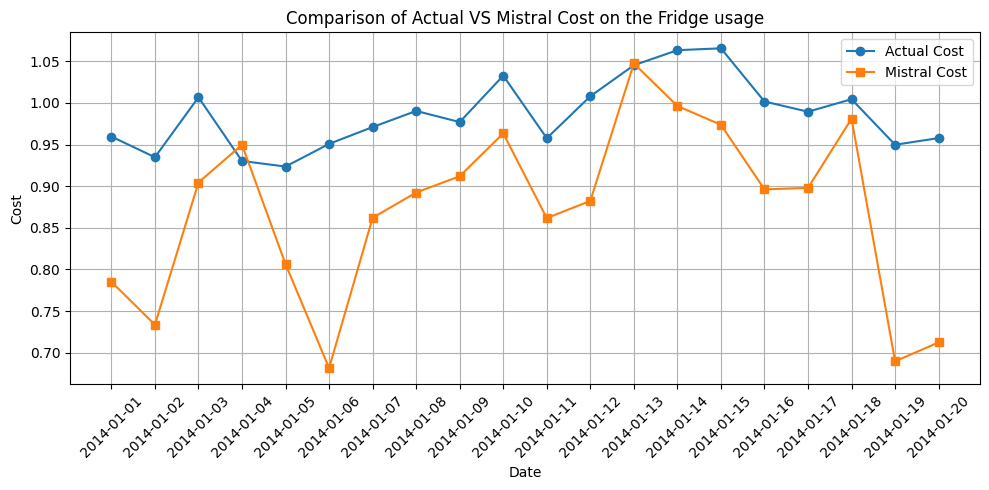

In [49]:
# Given dictionaries
#dict1 = {'2014-01-01': 0.9595631857213822, '2014-01-02': 0.9347714808920824, '2014-01-03': 1.0067462056031988, '2014-01-04': 0.9302405227936258, '2014-01-05': 0.9235501592712765}
#dict2 = {'2014-01-01': 0.9544651540929909, '2014-01-02': 0.9016743663752488, '2014-01-03': 0.950624147246825, '2014-01-04': 0.8997949478218772, '2014-01-05': 0.6745772700419963}

# Extract dates and values from dictionaries
dates1, values1 = zip(*sorted(actual_results.items()))
dates2, values2 = zip(*sorted(mistral_results.items()))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(dates1, values1, label='Actual Cost', marker='o')
plt.plot(dates2, values2, label='Mistral Cost', marker='s')
plt.title('Comparison of Actual VS Mistral Cost on the Fridge usage')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Note finali.
Non funziona granché se vengono integrati i costi e si richiedono i conteggi totali (v. esperimenti sotto). Meglio dare a Mistral solo gli orari e fare i calcoli economici con funzioni mie. Eliminati i prezzi anche dal prompt. Viene detto solo fascia più cara e fascia meno cara. Poi calcolo il costo per fascia e il costo totale. (v. PROMPT in basso in cui chiedo di evitare spiegazioni).

In [ ]:
prompt = """
The hourly rates for electricity are as follows:

F1 (Most expensive) -> From 08:00:00 to 19:00:00, Monday to Friday. Cost: €0.07138 per kWh.
F23 (Less expensive) -> From 19:00:00 to 08:00:00, Monday to Friday. And all day Saturday and Sunday. Cost: €0.06999 per kWh.

The Fridge consumes 150 watts.

During the day: 2013-10-12, the Fridge has been ON at these times:
From: 01:03:30 To: 03:03:30 -> COST: 0.3kwh x 0.06999 € = 0.020997€
From: 03:49:00 To: 06:49:00 -> COST: 0.9kwh x 0.06999 € = 0.062991€
From: 06:00:00 To: 09:00:00 -> COST: (0.3kwh x 0.06999 €) + (0.15kwh x 0.07138 €)= 0.020997€ + 0.010707€ = 0.031704€

TOTAL COST: 0.115692€
Propose a new scheduling, based only on shifting intervals, to reduce electricity cost. Compute the total cost of the new scheduling.
"""

In [ ]:
response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
answer = str(response["choices"][0]["text"]).strip().lower()
#print(response)
print(answer)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2477.63 ms
llama_print_timings:      sample time =     642.94 ms /   389 runs   (    1.65 ms per token,   605.03 tokens per second)
llama_print_timings: prompt eval time =     869.92 ms /   408 tokens (    2.13 ms per token,   469.01 tokens per second)
llama_print_timings:        eval time =   66838.53 ms /   388 runs   (  172.26 ms per token,     5.81 tokens per second)
llama_print_timings:       total time =   77852.27 ms /   796 tokens


to minimize the cost, we want to schedule the fridge's usage during the f23 tariff as much as possible. we can shift its usage from peak hours (f1) to off-peak hours (f23). let's try shifting the 06:00:00 - 09:00:00 interval to the night.

from: 06:00:00 to: new_end -> cost: (150 watts * 3 hours)/1000 = 0.45kwh x 0.06999 € = 0.031382€
we don't know the new end time yet, but we want it to be within the f23 tariff:
from 19:00:00 to 08:00:00, saturday and sunday

the earliest possible shift is from 19:30:00 since there are no other available slots before. let's calculate the cost for this new scheduling:

cost of 01:03:30 - 03:03:30 interval (f23): 0.020997€
cost of 03:49:00 - new_end interval (f23): 0.45kwh x 0.06999 € = 0.031382€

total cost: 0.052379€

the new scheduling reduces the electricity cost by approximately 53% compared to the original one, from 0.011569€ to 0.005238€.


In [ ]:
response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
answer = str(response["choices"][0]["text"]).strip().lower()
#print(response)
print(answer)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2477.63 ms
llama_print_timings:      sample time =     266.90 ms /   219 runs   (    1.22 ms per token,   820.53 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   34717.44 ms /   219 runs   (  158.53 ms per token,     6.31 tokens per second)
llama_print_timings:       total time =   37109.03 ms /   220 tokens


one possible solution could be turning off the fridge during the peak hours (between 8am and 7pm) and keep it on at night:
from: 19:00:00 to: 08:00:00 -> cost: 12 hours x 0.06999 €/kwh x 0.015 kw = 0.095988€

this new scheduling would save us more than 50% of the initial cost (approximately 0.021704€) and reduce our carbon footprint by using less energy during peak hours when it's produced from fossil fuels. however, we should consider that turning the fridge off for long periods can lead to food spoilage or even damage to the fridge itself if not done properly. it might be worth investigating more energy-efficient refrigerators or alternative solutions like solar panels for powering the fridge during off-peak hours.


In [ ]:
response = lcpp_llm(
                    prompt=prompt,
                    max_tokens = None,
                    #temperature= 0.9,
                    #logprobs=1,
                )
answer = str(response["choices"][0]["text"]).strip().lower()
#print(response)
print(answer)

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2477.63 ms
llama_print_timings:      sample time =     285.78 ms /   334 runs   (    0.86 ms per token,  1168.73 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   47853.99 ms /   334 runs   (  143.28 ms per token,     6.98 tokens per second)
llama_print_timings:       total time =   50565.41 ms /   335 tokens


to reduce electricity cost, we should try to maximize the use of the cheaper rate f23 whenever possible. here's a proposed scheduling:

from: 01:03:30 to: 08:00:00 -> the fridge can be off during this time as it is covered by f23 rate.
from: 08:00:01 to: 09:00:00 -> cost: 0.5kwh x 0.07138 € = 0.03569 €
from: 09:01:00 to: 20:00:00 -> the fridge can be on during this time as it is covered by f1 rate, but try to minimize the usage if possible.
from: 20:00:01 to: 23:59:59 -> the fridge should be off during this time as it is covered by f23 rate.

total cost: 0.03569 € + (0.15kwh x 0.06999 €) = 0.041884€

by scheduling the fridge to be off during most of the day when f23 rate applies and on only during late night when energy usage is low, we can reduce the electricity cost from 0.115692€ to 0.041884€.
